<a href="https://colab.research.google.com/github/HakujouRyu/DS-Unit-2-Kaggle-Challenge/blob/master/module1/assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
import numpy as np
import seaborn as sns
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import graphviz
from sklearn.tree import export_graphviz


In [4]:
train, val = train_test_split(train, stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((44550, 41), (14850, 41), (14358, 40))

In [0]:
def wrangle(X):
    
    # Warning
    X = X.copy()
    #Replace zeros and near zeros
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    cols_with_zeros = ['longitude', 'latitude', 'longitude', 'construction_year', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns=['extraction_type_class', 'extraction_type_group', 'quantity_group', 'payment', 'source', 'waterpoint_type_group', 'id'])
    
    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
    #Convert to DateTime and separate.
def dates(x):
    x['date_recorded'] = pd.to_datetime(x['date_recorded'])
    x['year_recorded'] = x['date_recorded'].dt.year
    x['month_recorded'] = x['date_recorded'].dt.month
    x = x.drop(columns='date_recorded')
    return(x)

In [0]:
train = dates(train)
val = dates(val)
test = dates(test)

In [0]:
target = 'status_group'
train_features = train.drop(columns=[target])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()
features = numeric_features + categorical_features

In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [10]:
X_train.head()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,year_recorded,month_recorded,basin,region,public_meeting,recorded_by,scheme_management,permit,extraction_type,management,management_group,payment_type,water_quality,quality_group,quantity,source_type,source_class,waterpoint_type
35240,200.0,1757,34.588740,-9.786994,0,11,5,75.0,2001.0,2011,3,Lake Nyasa,Iringa,True,GeoData Consultants Ltd,VWC,False,gravity,vwc,user-group,monthly,soft,good,enough,spring,groundwater,communal standpipe
16282,0.0,1664,31.739103,-8.771693,0,15,2,300.0,1994.0,2011,8,Lake Rukwa,Rukwa,True,GeoData Consultants Ltd,VWC,False,nira/tanira,vwc,user-group,never pay,soft,good,enough,shallow well,groundwater,hand pump
57019,0.0,0,33.922908,-9.499151,0,12,3,NaN,NaN,2011,7,Lake Nyasa,Mbeya,True,GeoData Consultants Ltd,VWC,True,gravity,vwc,user-group,monthly,soft,good,enough,spring,groundwater,communal standpipe
30996,0.0,1532,34.820269,-11.108757,0,10,3,260.0,2005.0,2013,3,Lake Nyasa,Ruvuma,NaN,GeoData Consultants Ltd,WUG,True,gravity,wug,user-group,unknown,soft,good,enough,spring,groundwater,communal standpipe
21149,50.0,-27,38.900501,-6.451608,0,6,1,20.0,2009.0,2011,3,Wami / Ruvu,Pwani,True,GeoData Consultants Ltd,Company,True,ksb,private operator,commercial,per bucket,soft,good,enough,river/lake,surface,communal standpipe


In [19]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(max_depth=20, min_samples_leaf=25,random_state=42)
)
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'recorded_by', 'scheme_management',
                                     'permit', 'extraction_type', 'management',
                                     'management_group', 'payment_type',
                                     'water_quality', 'quality_group',
                                     'quantity', 'source_type', 'source_class',
                                     'waterpoint_type'],
                               drop_invariant=False, handle_missing='value',
                               handle_u...
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=20, max_features=None,
           

In [20]:
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.7948597081930415
Validation Accuracy 0.764983164983165


In [0]:
y_pred = pipeline.predict(X_test)

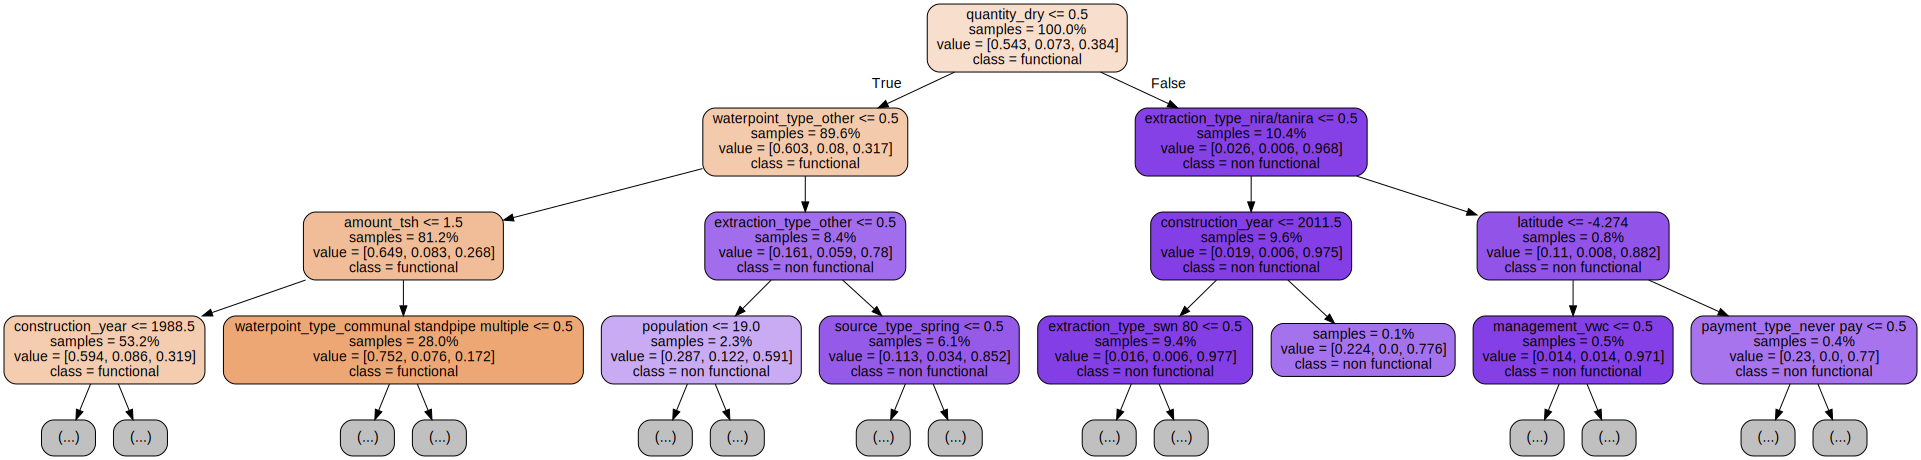

In [22]:
model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

In [0]:
sample_submission['status_group'] = y_pred

In [0]:
sample_submission.to_csv('Dtree_Sub2.csv', index=False)

In [0]:
sample_submission = pd.read_csv('Dtree_Sub2.csv')

In [26]:
sample_submission

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
5,52449,functional
6,24806,non functional
7,28965,non functional
8,36301,non functional
9,54122,functional
